# Linear Regression & Best Subset Selection
DSO 530 Spring 2024 Final Project \
Group 49: Jessica Bratahani, Pin Hsuan Chang, Suhan Ho, Sheena Huang, Yunchi Lee

In [1]:
import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Training Data

In [2]:
df_train=pd.read_csv('option_train.csv',index_col=0)

In [3]:
df_train.head()

,Value,S,K,tau,r,BS
1,348.500,1394.46,1050,0.128767,0.0116,Under
2,149.375,1432.25,1400,0.679452,0.0113,Under
3,294.500,1478.90,1225,0.443836,0.0112,Under
4,3.375,1369.89,1500,0.117808,0.0119,Over
5,84.000,1366.42,1350,0.298630,0.0119,Under


In [4]:
#checking for any null values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
 5   BS      5000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 273.4+ KB


In [5]:
#Correlation matrix
matrix = df_train.corr(numeric_only=True)
print("Correlation matrix: ")
print(matrix)

Correlation matrix: 
          Value         S         K       tau         r
Value  1.000000  0.148884 -0.880802  0.255343 -0.163317
S      0.148884  1.000000  0.128228 -0.020299 -0.983740
K     -0.880802  0.128228  1.000000  0.022948 -0.111107
tau    0.255343 -0.020299  0.022948  1.000000  0.010245
r     -0.163317 -0.983740 -0.111107  0.010245  1.000000


## Linear Regression

In [6]:
mlr = LinearRegression()  
X_train = df_train[['S','K','tau','r']].values
y_train = df_train['Value'].values

mlr.fit(X_train,y_train)
r_sq_house=mlr.score(X_train,y_train)
print('In Sample R2:',r_sq_house)
#r_sq_house=lm.score(X_test,y_test)
#print('Out of Sample R2:',r_sq_house)
y_train_pred = mlr.predict(X_train)
MSE = np.square(np.subtract(y_train,y_train_pred)).mean() 
print('MSE: ',MSE)

In Sample R2: 0.9249785018883101
MSE:  1174.8847708553976


In [7]:
mlr = LinearRegression()
X_train = df_train[['S','K','tau']].values
y_train = df_train['Value'].values

mlr.fit(X_train,y_train)
r_sq_house=mlr.score(X_train,y_train)
print('In Sample R2:',r_sq_house)

y_train_pred = mlr.predict(X_train)
MSE = np.square(np.subtract(y_train,y_train_pred)).mean() 
print('MSE: ',MSE)

In Sample R2: 0.9249766211573232
MSE:  1174.9142243087429


## Best Subset Selection for Linear Regression
Best Subset Selection is still feasible in our case, because we only have 4 parameters to predict y(Value), therefore our group chose to proceed with Best Subset Selection compared to Forward or Backward Stepwise selection.

In [8]:
def processSubset(feature_set,y):
    # Fit model on feature_set and calculate RSS 
    X1 = sm.add_constant(X[list(feature_set)]) 
    model = sm.OLS(y,X1)
    regr = model.fit()
    RSS = ((regr.predict(X1) - y) ** 2).sum() 
    return {"model":regr, "RSS":RSS}

In [9]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k): 
        results.append(processSubset(combo,y_train))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the smallest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    # idxmin() function returns index of first occurrence of minimum.
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in",(toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [10]:
X= df_train[['S','K','tau','r']]
models = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(0,5): 
    models.loc[i] = getBest(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
 

Processed  1 models on 0 predictors in 0.0030939579010009766 seconds.
Processed  4 models on 1 predictors in 0.011147022247314453 seconds.
Processed  6 models on 2 predictors in 0.010612964630126953 seconds.
Processed  4 models on 3 predictors in 0.004215717315673828 seconds.
Processed  1 models on 4 predictors in 0.0011038780212402344 seconds.
Total elapsed time: 0.03296208381652832 seconds.


In [11]:
models.sort_values('RSS')

,RSS,model
4,5874423.854277,<statsmodels.regression.linear_model.Regressio...
3,5874571.121544,<statsmodels.regression.linear_model.Regressio...
2,11605816.160791,<statsmodels.regression.linear_model.Regressio...
1,17554565.66617,<statsmodels.regression.linear_model.Regressio...
0,78303206.442656,<statsmodels.regression.linear_model.Regressio...


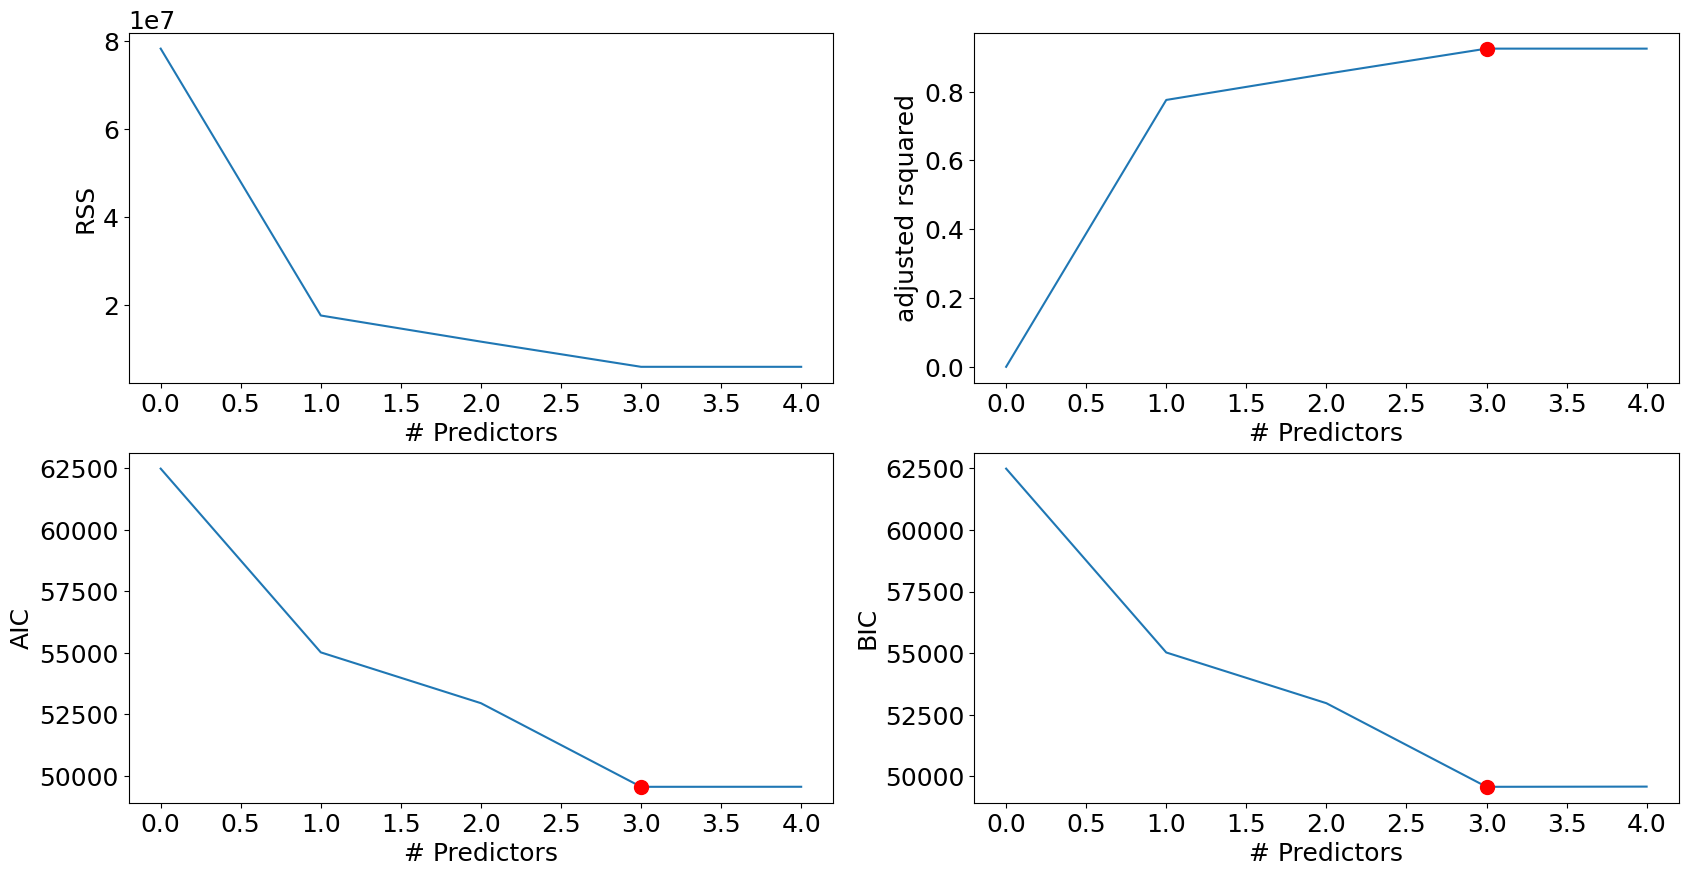

In [12]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
# We will now plot a curve to show the relationship between the number of predictors and the RSS
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The idxmax() function can be used to identify the location of the maximum point of a vector
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')
plt.savefig('BSS_LinearReg.png')

### Best OLS Regression Results with 3 predictors 

In [13]:
print(getBest(3)["model"].summary())

Processed  4 models on 3 predictors in 0.023597002029418945 seconds.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 2.053e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        14:36:35   Log-Likelihood:                -24767.
No. Observations:                5000   AIC:                         4.954e+04
Df Residuals:                    4996   BIC:                         4.957e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

### Best OLS Regression Results with 4 predictors 

In [14]:
print(getBest(4)["model"].summary())

Processed  1 models on 4 predictors in 0.0049169063568115234 seconds.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.540e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        14:36:35   Log-Likelihood:                -24767.
No. Observations:                5000   AIC:                         4.954e+04
Df Residuals:                    4995   BIC:                         4.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

### Verifying using K-Folds CV

In [15]:
from sklearn.model_selection import KFold ## for regression
from sklearn.model_selection import cross_val_score

kfolds_regresssion = KFold(n_splits = 5, random_state = 1, shuffle = True)

regression_model = LinearRegression()
#use r2 (the default) as the criterion for CV score, for other option add: scoring = neg_mean_squared_error
r2_model_1_cv = cross_val_score(regression_model, df_train[['S', 'K', 'tau', 'r']], df_train['Value'], cv=kfolds_regresssion) 
r2_model_2_cv = cross_val_score(regression_model, df_train[['S', 'K', 'tau']], df_train['Value'], cv=kfolds_regresssion)

print("Linear Regression:")
print("Model 1 (4 features): r squared of 5-folds:",r2_model_1_cv,"(mean r squared:",np.mean(r2_model_1_cv),")")
print("Model 2 (3 features): r squared of 5-folds:",r2_model_2_cv,"(mean r squared:",np.mean(r2_model_2_cv),")")

#mse_model_1_cv = cross_val_score(regression_model, df_train[['S', 'K', 'tau', 'r']], df_train['Value'], cv=kfolds_regresssion, scoring = neg_mean_squared_error) 
#mse_model_2_cv = cross_val_score(regression_model, df_train[['S', 'K', 'tau']], df_train['Value'], cv=kfolds_regresssion, scoring = neg_mean_squared_error)
#print("Linear Regression:")
#print("Model 1: mse of 5-folds:",r2_model_1_cv,"(mean mse:",np.mean(mse_model_1_cv),")")
#print("Model 2: mse of 5-folds:",r2_model_2_cv,"(mean mse:",np.mean(mse_model_2_cv),")")


Linear Regression:
Model 1 (4 features): r squared of 5-folds: [0.93093568 0.92857914 0.93000769 0.91180558 0.92195926] (mean r squared: 0.9246574701346504 )
Model 2 (3 features): r squared of 5-folds: [0.93094208 0.92858512 0.93001469 0.91183742 0.92198531] (mean r squared: 0.924672923615202 )


When looking closely at the OLS regression results from k-fold cross validation with 3 vs. 4 features, the difference in mean R-squared is less than 0.00001, therefore we decided to do regression on all 4 variables